In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
path = '/kaggle/input/mushrooms-classification-common-genuss-images/mushrooms/Mushrooms/'
df = pd.DataFrame()
for imlabel in os.listdir(path):
    for image in os.listdir(path+imlabel):
        df = df.append({"path" : path+imlabel+"/"+image, "label" : imlabel}, ignore_index=True)

df.head()

,path,label
0,/kaggle/input/mushrooms-classification-common-...,Entoloma
1,/kaggle/input/mushrooms-classification-common-...,Entoloma
2,/kaggle/input/mushrooms-classification-common-...,Entoloma
3,/kaggle/input/mushrooms-classification-common-...,Entoloma
4,/kaggle/input/mushrooms-classification-common-...,Entoloma


## Splitting Data :
70%, 20%, 10% for training, validation and testing respecitvely

In [3]:
train_X, val_test_X, train_Y, val_test_Y = train_test_split(df['path'], df['label'], test_size=0.3, shuffle=True)
train_data = pd.concat({'path':train_X, 'label':train_Y}, axis=1)

val_X, test_X, val_Y, test_Y = train_test_split(val_test_X, val_test_Y, test_size=0.33, shuffle=True)

validation_data = pd.concat({'path':val_X, 'label':val_Y}, axis=1)
test_data = pd.concat({'path':test_X, 'label':test_Y}, axis=1)

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
vertical_flip = True)
train_data_generator = train_datagen.flow_from_dataframe(train_data,
                                                         x_col = 'path',
                                                         y_col = 'label',
                                                        batch_size=32,
                                                         color_mode="rgb",
                                                         target_size=(224, 224),
                                                        class_mode="categorical")
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_data_generator = validation_datagen.flow_from_dataframe(validation_data,
                                                                   x_col = 'path',
                                                                   y_col = 'label',
                                                                   batch_size=32,
                                                                   color_mode="rgb",
                                                                   target_size=(224, 224),
                                                                   class_mode="categorical")

test_datagen = ImageDataGenerator(rescale=1./255)
test_data_generator = test_datagen.flow_from_dataframe(test_data,
                                         x_col = 'path',
                                          y_col = 'label',
                                          batch_size=test_data['path'].shape[0],
                                          color_mode="rgb",
                                          target_size=(224, 224),
                                          class_mode="categorical")

Found 4699 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 665 validated image filenames belonging to 9 classes.


In [5]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint ,EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report, accuracy_score, log_loss


#  DenseNet implementation

In [6]:
densenet1 = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

2022-01-18 02:46:37.711427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


29097984/29084464 [==============================] - 0s 0us/step


2022-01-18 02:46:37.801053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 02:46:37.801745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 02:46:37.803162: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-18 02:46:37.804378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [7]:
img_inputs = tensorflow.keras.Input(shape=(224, 224, 3))

x = densenet1(img_inputs)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
x = tensorflow.keras.layers.Dense(128, activation='relu')(x)

m_output = tensorflow.keras.layers.Dense(9, activation='softmax')(x)

model1 = tensorflow.keras.Model(inputs=img_inputs, outputs=m_output)

model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'Precision', 'Recall'])
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1161      
Total params: 7,169,865
Trainable params: 7,086,217
Non-trainable params: 83,648
_________________________________________________________________


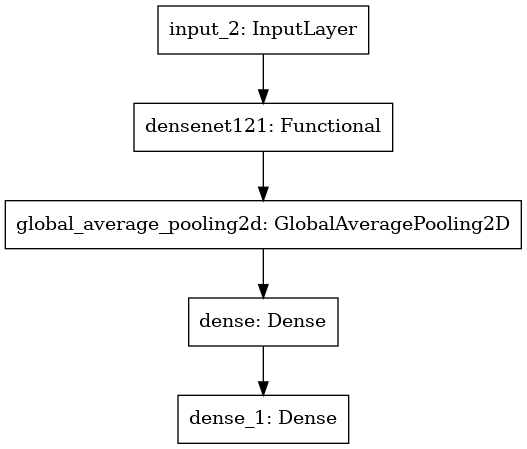

In [8]:
tensorflow.keras.utils.plot_model(model1)

In [9]:
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

early = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.09,patience=2)

epoch_num = 2

In [10]:
model1_path = '/kaggle/working/Model1.h5'
history1_path = '/kaggle/working/model1_history.npy'

if ((not os.path.exists(model1_path)) or (not os.path.exists(history1_path))):
    history1 = model1.fit(train_data_generator, epochs=epoch_num, validation_data=validation_data_generator, callbacks=[early, reduce_lr])
    history1 = history1.history
    model1.save_weights(model1_path)
    np.save(history1_path,history1)

else:
    p = input("Enter '0' if you want to train a new model, '1' to use a pretrained model and '2' to train a pretraind model")
    if (p=="0"):
        history1 = model1.fit(train_data_generator, epochs=epoch_num, validation_data=validation_data_generator, callbacks=[early, reduce_lr])
        history1 = history1.history
        np.save(history1_path,history1)
        model1.save_weights(model1_path)
    elif (p=="1"):
        model1.load_weights(model1_path)
        history1=np.load(history1_path,allow_pickle='TRUE').item()
    elif (p=="2"):
        model1.load_weights(model1_path)
        history1 = model1.fit(train_data_generator, epochs=epoch_num, validation_data=validation_data_generator, callbacks=[early, reduce_lr])
        history1 = history1.history
        np.save(history1_path,history1)
        model1.save_weights(model1_path)

2022-01-18 02:46:46.076021: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2022-01-18 02:46:57.568283: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


147/147 [==============================] - 152s 918ms/step - loss: 1.3718 - accuracy: 0.5242 - precision: 0.6894 - recall: 0.3684 - val_loss: 9.5001 - val_accuracy: 0.2030 - val_precision: 0.2072 - val_recall: 0.2015
Epoch 2/2
147/147 [==============================] - 102s 696ms/step - loss: 1.0122 - accuracy: 0.6514 - precision: 0.7689 - recall: 0.5446 - val_loss: 12.7512 - val_accuracy: 0.1874 - val_precision: 0.1892 - val_recall: 0.1844


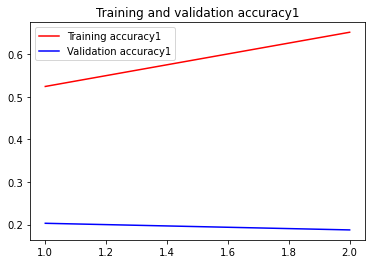

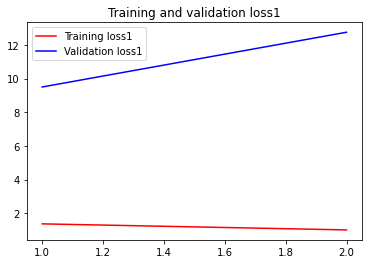

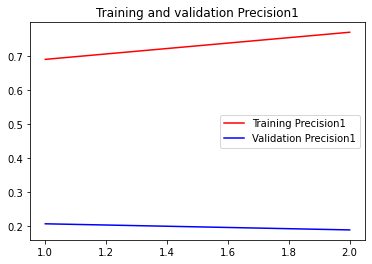

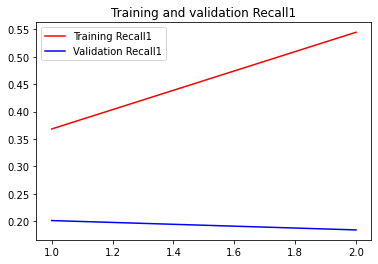

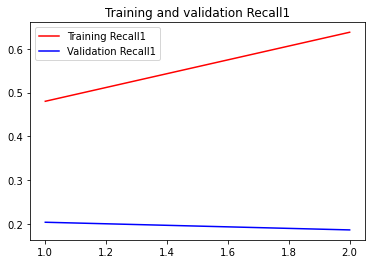

In [11]:
accuracy1 = history1['accuracy']
val_accuracy1 = history1['val_accuracy']
loss1 = history1['loss']
val_loss1 = history1['val_loss']
precision1 = history1['precision']
val_precision1 = history1['val_precision']
recall1 = history1['recall']
val_recall1 = history1['val_recall']
f1_score1 = 2 * (np.array(precision1) * np.array(recall1)) / (np.array(precision1) + np.array(recall1))
val_f1_score1 = 2 * (np.array(val_precision1) * np.array(val_recall1)) / (np.array(val_precision1) + np.array(val_recall1))

import matplotlib.pyplot as plt

epochs1 = range(1, len(accuracy1) + 1)

plt.plot(epochs1, accuracy1, 'r', label='Training accuracy1')
plt.plot(epochs1, val_accuracy1, 'b', label='Validation accuracy1')
plt.title('Training and validation accuracy1')
plt.legend()

plt.figure()

plt.plot(epochs1, loss1, 'r', label='Training loss1')
plt.plot(epochs1, val_loss1, 'b', label='Validation loss1')
plt.title('Training and validation loss1')
plt.legend()

plt.figure()

plt.plot(epochs1, precision1, 'r', label='Training Precision1')
plt.plot(epochs1, val_precision1, 'b', label='Validation Precision1')
plt.title('Training and validation Precision1')
plt.legend()

plt.figure()

plt.plot(epochs1, recall1, 'r', label='Training Recall1')
plt.plot(epochs1, val_recall1, 'b', label='Validation Recall1')
plt.title('Training and validation Recall1')
plt.legend()

plt.figure()
plt.plot(epochs1, f1_score1, 'r', label='Training Recall1')
plt.plot(epochs1, val_f1_score1, 'b', label='Validation Recall1')
plt.title('Training and validation Recall1')
plt.legend()

### DenseNet Model performance on Test data.

In [12]:
for image, lab in test_data_generator:
    break;

predict_y1 = model1.predict(image)

print(f"Test Accuracy  :  {accuracy_score(np.argmax(lab, axis=1), np.argmax(predict_y1, axis=1))}")
print(f"Test Loss      :   {sklearn.metrics.zero_one_loss(np.argmax(lab, axis=1), np.argmax(predict_y1, axis=1))}")
print(f"Test Precision :  {precision_score(np.argmax(lab, axis=1), np.argmax(predict_y1, axis=1), average='macro')}")
print(f"Test Recall    :  {recall_score(np.argmax(lab, axis=1), np.argmax(predict_y1, axis=1), average='macro')}")
print(f"Test F1_Score  :  {f1_score(np.argmax(lab, axis=1), np.argmax(predict_y1, axis=1), average='macro')}")

Test Accuracy  :  0.17142857142857143
Test Loss      :   0.8285714285714285
Test Precision :  0.3562281309430016
Test Recall    :  0.18203132874045824
Test F1_Score  :  0.12708683597039191


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrix heatmap

[Text(0.5, 15.0, 'true_value'), Text(33.0, 0.5, 'prediction')]

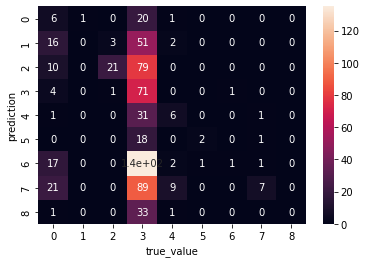

In [13]:
import seaborn as sns

cnf1 = tensorflow.math.confusion_matrix(np.argmax(lab, axis=1), np.argmax(predict_y1, axis=1))
c_plot1 = sns.heatmap(cnf1, annot=True)
c_plot1.set(xlabel='true_value', ylabel='prediction')

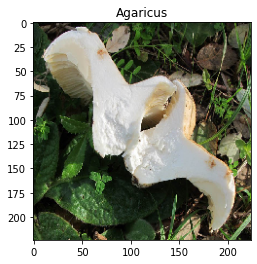

Wrong value prediction
Correct label is : Boletus


In [14]:
def show_predicted_image1(i):
    plt.imshow(image[i])
    plt.title(os.listdir(path)[np.argmax(predict_y1[i])])
    plt.show()
    if (np.argmax(predict_y1[i])==np.argmax(lab[i])):
        print("True prediction")
    else:
        print("Wrong value prediction")
        print(f"Correct label is : {os.listdir(path)[np.argmax(lab[i])]}")
        
show_predicted_image1(4)

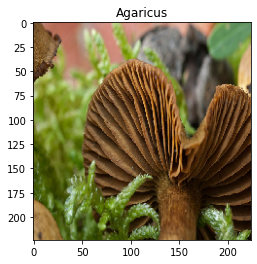

True prediction


In [15]:
show_predicted_image1(7)

## Classification report for test datset

In [16]:
print(classification_report(np.argmax(lab, axis=1), np.argmax(predict_y1, axis=1)))

              precision    recall  f1-score   support

           0       0.08      0.21      0.12        28
           1       0.00      0.00      0.00        72
           2       0.84      0.19      0.31       110
           3       0.13      0.92      0.24        77
           4       0.29      0.15      0.20        39
           5       0.67      0.10      0.17        21
           6       0.50      0.01      0.01       157
           7       0.70      0.06      0.10       126
           8       0.00      0.00      0.00        35

    accuracy                           0.17       665
   macro avg       0.36      0.18      0.13       665
weighted avg       0.45      0.17      0.12       665



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#  DenseNet + XceptionNet implementation

In [17]:
densenet2 = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [18]:
xceptionNet2 = tensorflow.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

83697664/83683744 [==============================] - 4s 0us/step


In [19]:
img_inputs = tensorflow.keras.Input(shape=(224, 224, 3))

x = densenet2(img_inputs)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
x = tensorflow.keras.layers.Dense(128, activation='relu')(x)

y = xceptionNet2(img_inputs)
y = tensorflow.keras.layers.GlobalAveragePooling2D()(y)
y = tensorflow.keras.layers.Dense(128, activation='relu')(y)

y = tensorflow.keras.layers.Concatenate()([x, y])
y = tensorflow.keras.layers.Dense(128, activation="relu")(y)

m_output = tensorflow.keras.layers.Dense(9, activation='softmax')(y)

model2 = tensorflow.keras.Model(inputs=img_inputs, outputs=m_output)

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'Precision', 'Recall'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet121 (Functional)        (None, 7, 7, 1024)   7037504     input_5[0][0]                    
__________________________________________________________________________________________________
xception (Functional)           (None, 7, 7, 2048)   20861480    input_5[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1024)         0           densenet121[0][0]                
____________________________________________________________________________________________

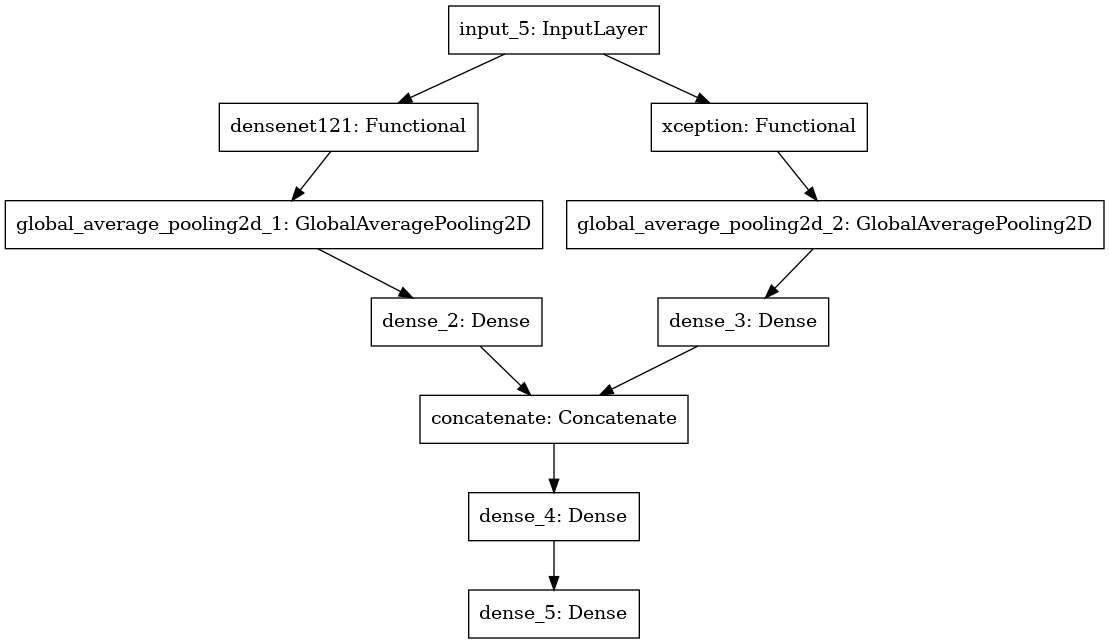

In [20]:
tensorflow.keras.utils.plot_model(model2)

In [21]:
model2_path = '/kaggle/working/Model2.h5'
history2_path = '/kaggle/working/model2_history.npy'

if ((not os.path.exists(model2_path)) or (not os.path.exists(history2_path))):
    history2 = model2.fit(train_data_generator, epochs=epoch_num, validation_data=validation_data_generator, callbacks=[early, reduce_lr])
    history2 = history2.history
    model2.save_weights(model2_path)
    np.save(history2_path,history2)

else:
    p = input("Enter '0' if you want to train a new model, '1' to use a pretrained model and '2' to train a pretraind model")
    if (p=="0"):
        history2 = model2.fit(train_data_generator, epochs=epoch_num, validation_data=validation_data_generator, callbacks=[early, reduce_lr])
        history2 = history2.history
        np.save(history2_path,history2)
        model2.save_weights(model2_path)
    elif (p=="1"):
        model2.load_weights(model2_path)
        history2=np.load(history2_path,allow_pickle='TRUE').item()
    elif (p=="2"):
        model2.load_weights(model2_path)
        history2 = model2.fit(train_data_generator, epochs=epoch_num, validation_data=validation_data_generator, callbacks=[early, reduce_lr])
        history2 = history2.history
        np.save(history2_path,history2)
        model2.save_weights(model2_path)

Epoch 1/2
147/147 [==============================] - 151s 918ms/step - loss: 1.4098 - accuracy: 0.5229 - precision: 0.7221 - recall: 0.3435 - val_loss: 2.6496 - val_accuracy: 0.4607 - val_precision: 0.4961 - val_recall: 0.4259
Epoch 2/2
147/147 [==============================] - 133s 903ms/step - loss: 0.9796 - accuracy: 0.6821 - precision: 0.7906 - recall: 0.5610 - val_loss: 1.8902 - val_accuracy: 0.4600 - val_precision: 0.5444 - val_recall: 0.3859


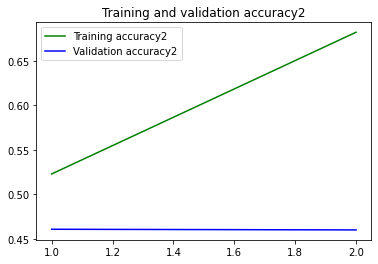

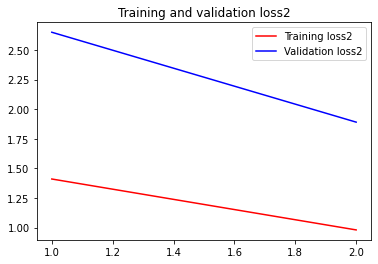

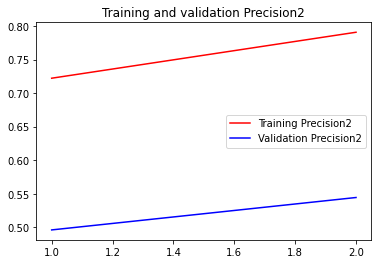

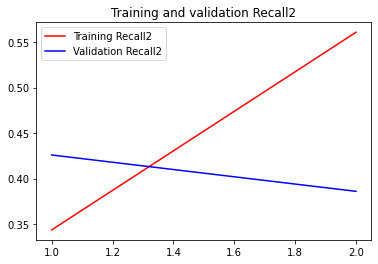

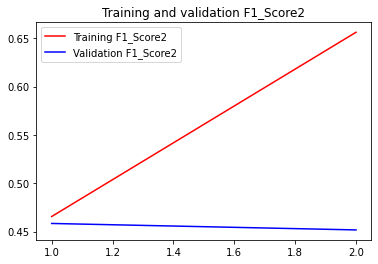

In [22]:
accuracy2 = history2['accuracy']
val_accuracy2 = history2['val_accuracy']
loss2 = history2['loss']
val_loss2 = history2['val_loss']
precision2 = history2['precision']
val_precision2 = history2['val_precision']
recall2 = history2['recall']
val_recall2 = history2['val_recall']
f1_score2 = 2 * (np.array(precision2) * np.array(recall2)) / (np.array(precision2) + np.array(recall2))
val_f1_score2 = 2 * (np.array(val_precision2) * np.array(val_recall2)) / (np.array(val_precision2) + np.array(val_recall2))

epochs2 = range(1, len(accuracy2) + 1)

plt.plot(epochs2, accuracy2, 'g', label='Training accuracy2')
plt.plot(epochs2, val_accuracy2, 'b', label='Validation accuracy2')
plt.title('Training and validation accuracy2')
plt.legend()

plt.figure()

plt.plot(epochs2, loss2, 'r', label='Training loss2')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss2')
plt.title('Training and validation loss2')
plt.legend()

plt.figure()

plt.plot(epochs2, precision2, 'r', label='Training Precision2')
plt.plot(epochs2, val_precision2, 'b', label='Validation Precision2')
plt.title('Training and validation Precision2')
plt.legend()

plt.figure()

plt.plot(epochs2, recall2, 'r', label='Training Recall2')
plt.plot(epochs2, val_recall2, 'b', label='Validation Recall2')
plt.title('Training and validation Recall2')
plt.legend()

plt.figure()

plt.plot(epochs2, f1_score2, 'r', label='Training F1_Score2')
plt.plot(epochs2, val_f1_score2, 'b', label='Validation F1_Score2')
plt.title('Training and validation F1_Score2')
plt.legend()

## DenseNet+XceptionNet Performance on Test data.

In [23]:
predict_y2 = model2.predict(image)

print(f"Test Accuracy  :  {accuracy_score(np.argmax(lab, axis=1), np.argmax(predict_y2, axis=1))}")
print(f"Test Loss      :  {sklearn.metrics.zero_one_loss(np.argmax(lab, axis=1), np.argmax(predict_y2, axis=1))}")
print(f"Test Precision :  {precision_score(np.argmax(lab, axis=1), np.argmax(predict_y2, axis=1), average='macro')}")
print(f"Test Recall    :  {recall_score(np.argmax(lab, axis=1), np.argmax(predict_y2, axis=1), average='macro')}")
print(f"Test F1_Score  :  {f1_score(np.argmax(lab, axis=1), np.argmax(predict_y2, axis=1), average='macro')}")

Test Accuracy  :  0.48120300751879697
Test Loss      :  0.518796992481203
Test Precision :  0.5252734567201416
Test Recall    :  0.4978123001477566
Test F1_Score  :  0.43380892600710186


## Confusion Matrix heatmap

[Text(0.5, 15.0, 'prediction'), Text(33.0, 0.5, 'true_value')]

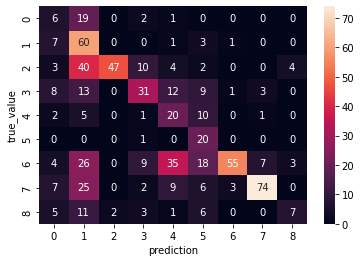

In [24]:
import seaborn as sns

cnf2 = tensorflow.math.confusion_matrix(np.argmax(lab, axis=1), np.argmax(predict_y2, axis=1))
c_plot2 = sns.heatmap(cnf2, annot=True)
c_plot2.set(xlabel='prediction', ylabel='true_value')

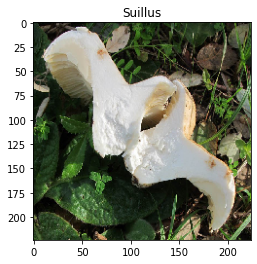

Wrong value prediction
Correct label is : Boletus


In [25]:
def show_predicted_image2(i):
    plt.imshow(image[i])
    plt.title(os.listdir(path)[np.argmax(predict_y2[i])])
    plt.show()
    if (np.argmax(predict_y2[i])==np.argmax(lab[i])):
        print("True prediction")
    else:
        print("Wrong value prediction")
        print(f"Correct label is : {os.listdir(path)[np.argmax(lab[i])]}")
        
show_predicted_image2(4)

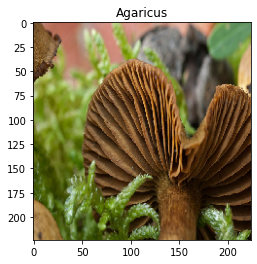

True prediction


In [26]:
show_predicted_image2(7)

In [27]:
print(classification_report(np.argmax(lab, axis=1), np.argmax(predict_y2, axis=1)))

              precision    recall  f1-score   support

           0       0.14      0.21      0.17        28
           1       0.30      0.83      0.44        72
           2       0.96      0.43      0.59       110
           3       0.53      0.40      0.46        77
           4       0.24      0.51      0.33        39
           5       0.27      0.95      0.42        21
           6       0.92      0.35      0.51       157
           7       0.87      0.59      0.70       126
           8       0.50      0.20      0.29        35

    accuracy                           0.48       665
   macro avg       0.53      0.50      0.43       665
weighted avg       0.69      0.48      0.51       665



# DenseNet + XceptionNet + ResNet implementation

In [28]:
densenet3 = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [29]:
xceptionNet3 = tensorflow.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

In [30]:
resNet3 = tensorflow.keras.applications.resnet.ResNet101(
    include_top=False, weights='imagenet',
    input_shape=(224, 224, 3)
)

171458560/171446536 [==============================] - 9s 0us/step


In [31]:
img_inputs = tensorflow.keras.Input(shape=(224, 224, 3))

x = densenet3(img_inputs)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
x = tensorflow.keras.layers.Dense(128, activation='relu')(x)

y = xceptionNet3(img_inputs)
y = tensorflow.keras.layers.GlobalAveragePooling2D()(y)
y = tensorflow.keras.layers.Dense(128, activation='relu')(y)

z = resNet3(img_inputs)
z = tensorflow.keras.layers.GlobalAveragePooling2D()(z)
z = tensorflow.keras.layers.Dense(128, activation='relu')(z)

z = tensorflow.keras.layers.Concatenate()([x, y, z])
z = tensorflow.keras.layers.Dense(128, activation="relu")(z)

m_output = tensorflow.keras.layers.Dense(9, activation='softmax')(z)

model3 = tensorflow.keras.Model(inputs=img_inputs, outputs=m_output)

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'Precision', 'Recall'])
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet121 (Functional)        (None, 7, 7, 1024)   7037504     input_9[0][0]                    
__________________________________________________________________________________________________
xception (Functional)           (None, 7, 7, 2048)   20861480    input_9[0][0]                    
__________________________________________________________________________________________________
resnet101 (Functional)          (None, 7, 7, 2048)   42658176    input_9[0][0]                    
____________________________________________________________________________________________

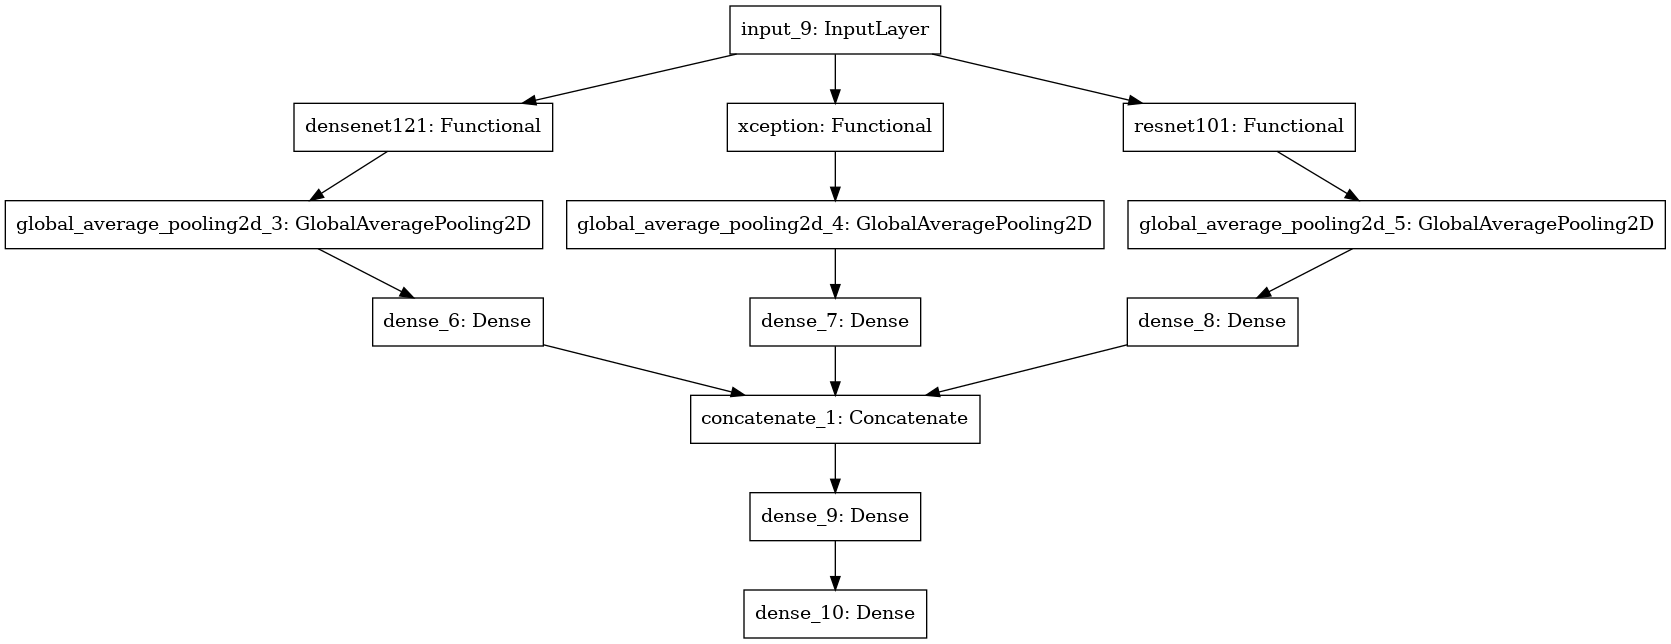

In [32]:
tensorflow.keras.utils.plot_model(model3)

In [33]:
model3_path = '/kaggle/working/Model3.h5'
history3_path = '/kaggle/working/model3_history.npy'

if ((not os.path.exists(model3_path)) or (not os.path.exists(history3_path))):
    history3 = model3.fit(train_data_generator, epochs=epoch_num, validation_data=validation_data_generator, callbacks=[early, reduce_lr])
    history3 = history3.history
    model3.save_weights(model3_path)
    np.save(history3_path,history3)

else:
    p = input("Enter '0' if you want to train a new model, '1' to use a pretrained model and '2' to train a pretraind model")
    if (p=="0"):
        history3 = model3.fit(train_data_generator, epochs=epoch_num, validation_data=validation_data_generator, callbacks=[early, reduce_lr])
        history3 = history3.history
        np.save(history3_path,history3)
        model3.save_weights(model3_path)
    elif (p=="1"):
        model3.load_weights(model3_path)
        history3=np.load(history3_path,allow_pickle='TRUE').item()
    elif (p=="2"):
        model3.load_weights(model3_path)
        history3 = model3.fit(train_data_generator, epochs=epoch_num, validation_data=validation_data_generator, callbacks=[early, reduce_lr])
        history3 = history3.history
        np.save(history3_path,history3)
        model3.save_weights(model3_path)

Epoch 1/2


2022-01-18 02:57:06.867706: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-18 02:57:06.878297: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-18 02:57:06.899699: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-18 02:57:06.908361: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Alloc

 44/147 [=======>......................] - ETA: 1:40 - loss: 1.7147 - accuracy: 0.3977 - precision: 0.6184 - recall: 0.2095

2022-01-18 02:57:50.067613: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-18 02:57:50.087133: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


147/147 [==============================] - 189s 1s/step - loss: 1.4851 - accuracy: 0.4837 - precision: 0.6954 - recall: 0.3124 - val_loss: 3.6144 - val_accuracy: 0.3370 - val_precision: 0.3598 - val_recall: 0.3222
Epoch 2/2
147/147 [==============================] - 160s 1s/step - loss: 1.0289 - accuracy: 0.6491 - precision: 0.7785 - recall: 0.5354 - val_loss: 3.0426 - val_accuracy: 0.3748 - val_precision: 0.3972 - val_recall: 0.3333


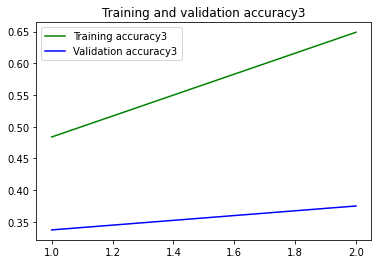

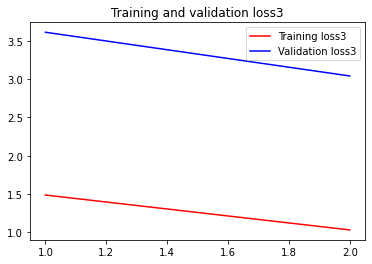

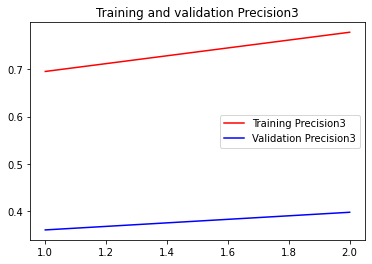

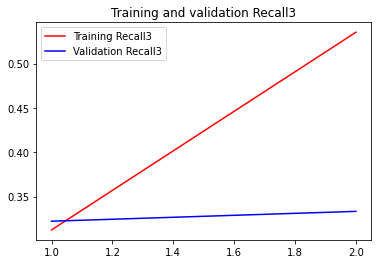

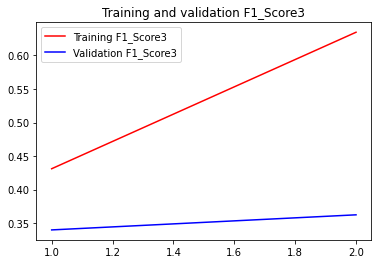

In [34]:
accuracy3 = history3['accuracy']
val_accuracy3 = history3['val_accuracy']
loss3 = history3['loss']
val_loss3 = history3['val_loss']
precision3 = history3['precision']
val_precision3 = history3['val_precision']
recall3 = history3['recall']
val_recall3 = history3['val_recall']
f1_score3 = 2 * (np.array(precision3) * np.array(recall3)) / (np.array(precision3) + np.array(recall3))
val_f1_score3 = 2 * (np.array(val_precision3) * np.array(val_recall3)) / (np.array(val_precision3) + np.array(val_recall3))

epochs3 = range(1, len(accuracy2) + 1)

plt.plot(epochs3, accuracy3, 'g', label='Training accuracy3')
plt.plot(epochs3, val_accuracy3, 'b', label='Validation accuracy3')
plt.title('Training and validation accuracy3')
plt.legend()

plt.figure()

plt.plot(epochs3, loss3, 'r', label='Training loss3')
plt.plot(epochs3, val_loss3, 'b', label='Validation loss3')
plt.title('Training and validation loss3')
plt.legend()

plt.figure()

plt.plot(epochs3, precision3, 'r', label='Training Precision3')
plt.plot(epochs3, val_precision3, 'b', label='Validation Precision3')
plt.title('Training and validation Precision3')
plt.legend()

plt.figure()

plt.plot(epochs3, recall3, 'r', label='Training Recall3')
plt.plot(epochs3, val_recall3, 'b', label='Validation Recall3')
plt.title('Training and validation Recall3')
plt.legend()

plt.figure()

plt.plot(epochs3, f1_score3, 'r', label='Training F1_Score3')
plt.plot(epochs3, val_f1_score3, 'b', label='Validation F1_Score3')
plt.title('Training and validation F1_Score3')
plt.legend()

In [35]:
predict_y3 = model3.predict(image)

print(f"Test Accuracy  :  {accuracy_score(np.argmax(lab, axis=1), np.argmax(predict_y3, axis=1))}")
print(f"Test Loss      :   {sklearn.metrics.zero_one_loss(np.argmax(lab, axis=1), np.argmax(predict_y3, axis=1))}")
print(f"Test Precision :  {precision_score(np.argmax(lab, axis=1), np.argmax(predict_y3, axis=1), average='macro')}")
print(f"Test Recall    :  {recall_score(np.argmax(lab, axis=1), np.argmax(predict_y3, axis=1), average='macro')}")
print(f"Test F1_Score  :  {f1_score(np.argmax(lab, axis=1), np.argmax(predict_y3, axis=1), average='macro')}")

Test Accuracy  :  0.362406015037594
Test Loss      :   0.6375939849624059
Test Precision :  0.47584248508686827
Test Recall    :  0.33133888797370753
Test F1_Score  :  0.2951902043250481


[Text(0.5, 15.0, 'prediction'), Text(33.0, 0.5, 'true_value')]

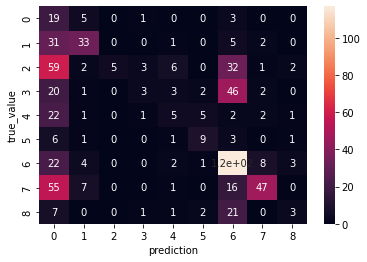

In [36]:
cnf3 = tensorflow.math.confusion_matrix(np.argmax(lab, axis=1), np.argmax(predict_y3, axis=1))
c_plot3 = sns.heatmap(cnf3, annot=True)
c_plot3.set(xlabel='prediction', ylabel='true_value')

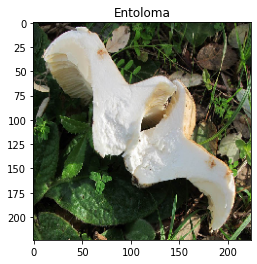

Wrong value prediction
Correct label is : Boletus


In [37]:
def show_predicted_image3(i):
    plt.imshow(image[i])
    plt.title(os.listdir(path)[np.argmax(predict_y3[i])])
    plt.show()
    if (np.argmax(predict_y3[i])==np.argmax(lab[i])):
        print("True prediction")
    else:
        print("Wrong value prediction")
        print(f"Correct label is : {os.listdir(path)[np.argmax(lab[i])]}")
        
show_predicted_image3(4)

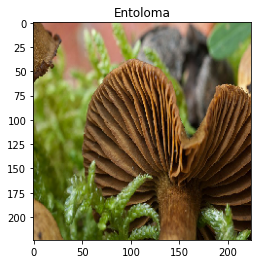

Wrong value prediction
Correct label is : Agaricus


In [38]:
show_predicted_image3(7)

In [39]:
print(classification_report(np.argmax(lab, axis=1), np.argmax(predict_y3, axis=1)))

              precision    recall  f1-score   support

           0       0.08      0.68      0.14        28
           1       0.61      0.46      0.52        72
           2       1.00      0.05      0.09       110
           3       0.33      0.04      0.07        77
           4       0.25      0.13      0.17        39
           5       0.47      0.43      0.45        21
           6       0.48      0.75      0.58       157
           7       0.76      0.37      0.50       126
           8       0.30      0.09      0.13        35

    accuracy                           0.36       665
   macro avg       0.48      0.33      0.30       665
weighted avg       0.58      0.36      0.35       665



# Plots for Comparison of Models

## 1. Train Accuracy plot.

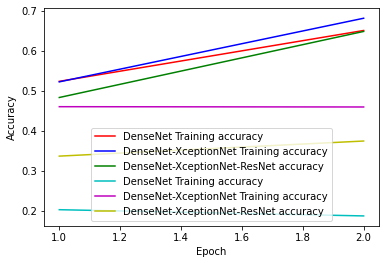

In [40]:
plt.figure()
plt.plot(epochs1, accuracy1, 'r', label='DenseNet Training accuracy')
plt.plot(epochs2, accuracy2, 'b', label='DenseNet-XceptionNet Training accuracy')
plt.plot(epochs3, accuracy3, 'g', label='DenseNet-XceptionNet-ResNet accuracy')
plt.plot(epochs1, val_accuracy1, 'c', label='DenseNet Training accuracy')
plt.plot(epochs2, val_accuracy2, 'm', label='DenseNet-XceptionNet Training accuracy')
plt.plot(epochs3, val_accuracy3, 'y', label='DenseNet-XceptionNet-ResNet accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 2. Training - Validation Loss plot.

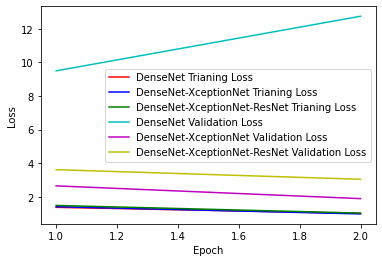

In [41]:
plt.figure()
plt.plot(epochs1, loss1, 'r', label='DenseNet Trianing Loss')
plt.plot(epochs2, loss2, 'b', label='DenseNet-XceptionNet Trianing Loss')
plt.plot(epochs3, loss3, 'g', label='DenseNet-XceptionNet-ResNet Trianing Loss')
plt.plot(epochs1, val_loss1, 'c', label='DenseNet Validation Loss')
plt.plot(epochs2, val_loss2, 'm', label='DenseNet-XceptionNet Validation Loss')
plt.plot(epochs3, val_loss3, 'y', label='DenseNet-XceptionNet-ResNet Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 3. Training - Validation Precision Plot

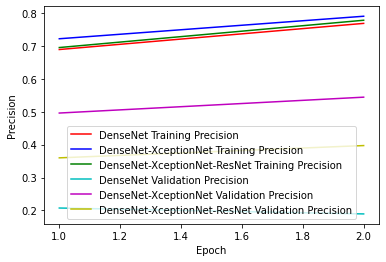

In [42]:
plt.figure()
plt.plot(epochs1, precision1, 'r', label='DenseNet Training Precision')
plt.plot(epochs2, precision2, 'b', label='DenseNet-XceptionNet Training Precision')
plt.plot(epochs3, precision3, 'g', label='DenseNet-XceptionNet-ResNet Training Precision')
plt.plot(epochs1, val_precision1, 'c', label='DenseNet Validation Precision')
plt.plot(epochs2, val_precision2, 'm', label='DenseNet-XceptionNet Validation Precision')
plt.plot(epochs3, val_precision3, 'y', label='DenseNet-XceptionNet-ResNet Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

## 4. Training - Validation Recall Plot.

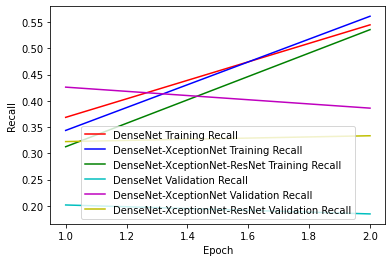

In [43]:
plt.figure()
plt.plot(epochs1, recall1, 'r', label='DenseNet Training Recall')
plt.plot(epochs2, recall2, 'b', label='DenseNet-XceptionNet Training Recall')
plt.plot(epochs3, recall3, 'g', label='DenseNet-XceptionNet-ResNet Training Recall')
plt.plot(epochs1, val_recall1, 'c', label='DenseNet Validation Recall')
plt.plot(epochs2, val_recall2, 'm', label='DenseNet-XceptionNet Validation Recall')
plt.plot(epochs3, val_recall3, 'y', label='DenseNet-XceptionNet-ResNet Validation Recall')
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.show()

## 5. Training F1_Score plot

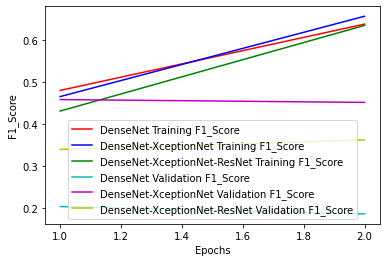

In [44]:
plt.figure()
plt.plot(epochs1, f1_score1, 'r', label='DenseNet Training F1_Score')
plt.plot(epochs2, f1_score2, 'b', label='DenseNet-XceptionNet Training F1_Score')
plt.plot(epochs3, f1_score3, 'g', label='DenseNet-XceptionNet-ResNet Training F1_Score')
plt.plot(epochs1, val_f1_score1, 'c', label='DenseNet Validation F1_Score')
plt.plot(epochs2, val_f1_score2, 'm', label='DenseNet-XceptionNet Validation F1_Score')
plt.plot(epochs3, val_f1_score3, 'y', label='DenseNet-XceptionNet-ResNet Validation F1_Score')
plt.xlabel('Epochs')
plt.ylabel('F1_Score')
plt.legend()
plt.show()

## All Models comparison for test dataset

In [55]:
cmp = pd.DataFrame({'DenseNet' : model1.evaluate(image, lab), 'DenseNet+XceptionNet' : model2.evaluate(image, lab), 'DenseNet+XceptionNet+ResNet' : model3.evaluate(image, lab)}, index=['Loss', 'Accuracy', 'Precision', 'Recall'])

21/21 [==============================] - 4s 213ms/step - loss: 3.2959 - accuracy: 0.3624 - precision: 0.3979 - recall: 0.3368


In [56]:
cmp

,DenseNet,DenseNet+XceptionNet,DenseNet+XceptionNet+ResNet
Loss,13.277932,1.815911,3.295927
Accuracy,0.171429,0.481203,0.362406
Precision,0.166667,0.562368,0.397869
Recall,0.160902,0.400000,0.336842
